# **Unzipping the data**

In [1]:
import zipfile
zip_file_path = '/content/drive/MyDrive/Copy of diffusion_datasets.zip'
extracted_dir = '/content/diffusion'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

In [2]:
import zipfile
zip_file_path = '/content/drive/MyDrive/Copy of CNN_synth_testset.zip'
extracted_dir = '/content/gan'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# **Pre-Processing of data**

  This function updates the image by applying gassian filter and then JPEG compression

In [1]:
import cv2
from PIL import Image
def preprocess(orignal):
    #Gaussian Blur
    kernel_size = (5, 5)
    blurred_image = cv2.GaussianBlur(orignal, kernel_size, 0)

    #JPEG comppression
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 85]
    _, comp = cv2.imencode('.jpg', blurred_image, encode_param)
    comp = cv2.imdecode(comp, 1)
    return comp

Reading data and storing in respective folders

In [2]:
import os
import numpy as np
real_img=[]
fake_img=[]
folders=os.listdir("/content/gan/progan")
os.chdir("/content/gan/progan")
for i in folders:
    content=os.listdir(i)

    path=os.path.join(i,content[0])
    subfld=os.listdir(path)
    for j in subfld:
        img_path=os.path.join(i,content[0],j)
        img=np.array(Image.open(img_path))
        if len(np.shape(img))==3:
            real_img.append(img)

    path=os.path.join(i,content[1])
    subfld=os.listdir(path)
    for j in subfld:
        img_path=os.path.join(i,content[1],j)
        img=np.array(Image.open(img_path))
        if len(np.shape(img))==3:
            fake_img.append(img)


In [3]:
print(np.shape(fake_img))
print(np.shape(real_img))

(4000, 256, 256, 3)
(4000, 256, 256, 3)


# Showing the effect of preprocessing

In [4]:
image_to_show=np.array(Image.open("/content/gan/progan/airplane/0_real/00049.png"))
image_preprocessed=preprocess(image_to_show)

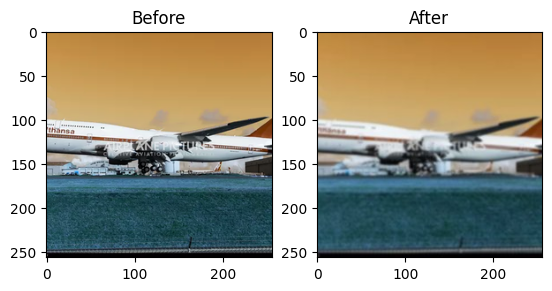

In [5]:
import cv2
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image_to_show,cv2.COLOR_BGR2RGB))
plt.title("Before")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(image_preprocessed,cv2.COLOR_BGR2RGB))
plt.title("After")
plt.show()

Applying preprocessing to real images

In [6]:
real=[preprocess(i) for i in real_img]
np.shape(real)

(4000, 256, 256, 3)

Applying preprocessing to fake images

In [7]:
fake=[preprocess(i) for i in fake_img]
np.shape(fake)

(4000, 256, 256, 3)

Preparaing Testing Data from Diffusion Models

In [8]:
test_images=[]
test_label=[]
path="/content/diffusion/diffusion_datasets/glide_100_10/1_fake"
l=os.listdir(path)
for i in l:
    img=np.array(Image.open(os.path.join(path,i)))
    if len(np.shape(img))==3:
        test_images.append(img)
        test_label.append(1)

In [9]:
path="/content/diffusion/diffusion_datasets/guided/1_fake"
l=os.listdir(path)
for i in l:
    img=np.array(Image.open(os.path.join(path,i)))
    if len(np.shape(img))==3:
        test_images.append(img)
        test_label.append(1)

In [10]:
path="/content/diffusion/diffusion_datasets/dalle/1_fake"
l=os.listdir(path)
for i in l:
    img=np.array(Image.open(os.path.join(path,i)))
    if len(np.shape(img))==3:
        test_images.append(img)
        test_label.append(1)

In [11]:
path="/content/diffusion/diffusion_datasets/ldm_100/1_fake"
l=os.listdir(path)
for i in l:
    img=np.array(Image.open(os.path.join(path,i)))
    if len(np.shape(img))==3:
        test_images.append(img)
        test_label.append(1)

Applying preprocessing steps to the testing data

In [12]:
test=[preprocess(i) for i in test_images]
print(np.shape(test))
print(np.shape(test_label))

(4000, 256, 256, 3)
(4000,)


# **Importing the libraries**

In [13]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yibd5mrx
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yibd5mrx
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


In [14]:
import torch
from pkg_resources import packaging
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split

In [15]:
import clip
for i in clip.available_models():
  if i=="ViT-L/14":
      print("Model Found")
      break
  else:
    print("Searching...")

Searching...
Searching...
Searching...
Searching...
Searching...
Searching...
Searching...
Model Found


Taking CLIP model from Transformers
(tried using this method to import clip model , but it was not working)

In [16]:
# from transformers import CLIPProcessor, CLIPModel
# import torch

# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")

# Imported the clip model from Github above

In [17]:
model, preprocess_model = clip.load("ViT-L/14")
model.cuda().eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
          )
          (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)


Preprocessing the data from the preprocess function of clip model

In [18]:
real_t=[]
for i in range(1000):
  temp=Image.fromarray(real[i])
  real_t.append(preprocess_model(temp))

In [19]:
fake_t=[]
for i in range(1000):
  temp=Image.fromarray(fake[i])
  fake_t.append(preprocess_model(temp))

In [20]:
test_t=[]
for i in range(1000):
  temp=Image.fromarray(test[i])
  test_t.append(preprocess_model(temp))

Converting to tensor

In [21]:
real_tr=torch.tensor(np.stack(real_t)).cuda()
fake_tr=torch.tensor(np.stack(fake_t)).cuda()
test_tr=torch.tensor(np.stack(test_t)).cuda()

In [22]:
real_tr.shape

torch.Size([1000, 3, 224, 224])

Extracting features from the images using Clip architecture

In [23]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
real_tr = real_tr.to(device)
with torch.no_grad():
    features_real = model.encode_image(real_tr).float()
features_real.shape


torch.Size([1000, 768])

In [24]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
fake_tr = fake_tr.to(device)
with torch.no_grad():
    features_fake = model.encode_image(fake_tr).float()
features_fake.shape


torch.Size([1000, 768])

In [25]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
test_tr = test_tr.to(device)
with torch.no_grad():
    features_test = model.encode_image(test_tr).float()
features_test.shape


torch.Size([1000, 768])

In [32]:
features_real=features_real.cpu().numpy()
features_fake=features_fake.cpu().numpy()
features_test=features_test.cpu().numpy()

In [28]:
def nearest_neighbor_classification(train_features_real,train_features_fake,test_feature):
    knn_real = NearestNeighbors(n_neighbors=1, metric='cosine')
    knn_real.fit(features_real)

    knn_fake = NearestNeighbors(n_neighbors=1, metric='cosine')
    knn_fake.fit(features_fake)

    _, indices_real = knn_real.kneighbors(test_feature.reshape(1, -1))
    _, indices_fake = knn_fake.kneighbors(test_feature.reshape(1, -1))

    distance_real = indices_real[0][0]
    distance_fake = indices_fake[0][0]

    predicted_label = 0 if distance_real < distance_fake else 1

    return predicted_label

In [33]:
lable_real=np.array([0]*1000)
lable_fake=np.array([1]*1000)

In [34]:
correct_predictions = 0
total_samples = len(features_test)

for i in range(total_samples):
    test_feature = features_test[i]
    true_label=1
    predicted_label = nearest_neighbor_classification(
        lable_real,
        lable_fake,
        test_feature
    )
    correct_predictions += 1 if predicted_label == true_label else 0

accuracy = correct_predictions / total_samples
print(f"Nearest Neighbor Classification Accuracy: {accuracy}")

Nearest Neighbor Classification Accuracy: 0.451
